# Plotting CESM Output

Contents:
- Maps of CESM output (chemical compounds)
- Maps of CESM-SE output, and regional refinement projections
- Zonal average contour plots (including calculating ZA)
- Difference maps - how to choose different color bars
- Panel map plots with different legends
- Box-plots (percentiles)
- Polar graph (e.g. wind rose)
- Multi-panel graph (customizing sizes and locations of each panel)
- Add flow stream lines on contour map

---

## Let's read some CESM and CESM-SE data

To do this, we need to use `xarray`.

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np

And now lets read CAM-chem on SE ne30 grid from GLADE.

In [2]:
file_pattern = "/glade/scratch/emmons/PYTHON_TUTORIAL/f.e20.FCHIST.ne30_ne30_mg17.cam6_1_019.GEOS5_nudged.next_obs.timescale0.cam.h1.2013-*.nc"

ds = xr.open_mfdataset(file_pattern).load()

In [3]:
ds

<xarray.Dataset>
Dimensions:       (ilev: 33, lev: 32, nbnd: 2, ncol: 48602, time: 12)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2013-02-01 00:00:00 ... 2014-01-01 00:00:00
Dimensions without coordinates: nbnd, ncol
Data variables:
    lat           (time, ncol) float64 -35.26 -35.65 -36.26 ... 36.68 36.05
    lon           (time, ncol) float64 315.0 315.8 317.2 ... 133.7 136.3 135.0
    area          (time, ncol) float64 4.397e-05 0.0001465 ... 0.0003665
    hyam          (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm          (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    hyai          (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.0 0.0
    hybi          (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9636 0.9851 1.0
    date          (time) int32 20130201 20130301 20130401 ... 2013

In [4]:
# Set all invariant variables to be coords.
invariants = [v for v in ds.variables if not {'ncol', 'time'}.issubset(set(ds[v].dims))]
invariants.extend(['lat', 'lon', 'area'])
print(invariants)

['lev', 'ilev', 'hyam', 'hybm', 'hyai', 'hybi', 'time', 'date', 'datesec', 'time_bnds', 'date_written', 'time_written', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'mdt', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'lat', 'lon', 'area']


In [5]:
ds = ds.set_coords(invariants)
ds

<xarray.Dataset>
Dimensions:       (ilev: 33, lev: 32, nbnd: 2, ncol: 48602, time: 12)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
    lat           (time, ncol) float64 -35.26 -35.65 -36.26 ... 36.68 36.05
    lon           (time, ncol) float64 315.0 315.8 317.2 ... 133.7 136.3 135.0
    area          (time, ncol) float64 4.397e-05 0.0001465 ... 0.0003665
    hyam          (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm          (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    hyai          (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.0 0.0
    hybi          (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9636 0.9851 1.0
  * time          (time) object 2013-02-01 00:00:00 ... 2014-01-01 00:00:00
    date          (time) int32 20130201 20130301 20130401 ... 20131201 20140101
    datesec       (time) int32 0 0 0 0 0 0 0 

## Maps of CESM output (chemical compounds)

Here we show how to visualize data on an unstructure grid using `cartopy` and `matplotlib`. To plot this dataset, we will need to read the topology of the dataset into a triangular mesh using `matplotlib`.

First, let's transform longitude values from 0 - 360 range to -180 - 180 range

In [6]:
ds.lon.data.min(), ds.lon.data.max()

(0.0, 360.0)

In [7]:
lons = np.mod(ds.lon.data[0] - 180.0, 360.0) - 180.0
lons.min(), lons.max()

(-180.0, 179.17082039324998)

In [8]:
lats = ds.lat.data[0]
print(lons.shape, lats.shape)

(48602,) (48602,)


In [9]:
import matplotlib.tri as tri
import matplotlib as mpl

In [10]:
triang = tri.Triangulation(lons, lats)

Matplotlib just created an unstructured triangular grid consisting of npoints points and
ntri triangles. Since we didn't specify the indices of the three points that make
up the triangle, matpotlib automatically generates triangles using a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).

In [11]:
triang.edges.shape

(145443, 2)

In [12]:
triang.edges

array([[    1,     0],
       [    2,     1],
       [    3,     2],
       ...,
       [48601, 48598],
       [48601, 48599],
       [48601, 48600]], dtype=int32)

Let's take a quick look at the mesh:

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_quick_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

Let's get one sample from the dataset to look at

In [14]:
sample = ds.isel(lev=0, time=slice(0, 1))[['O3']]
sample

<xarray.Dataset>
Dimensions:       (ncol: 48602, time: 1)
Coordinates:
    ch4vmr        (time) float64 1.824e-06
    nbdate        (time) int32 20130101
    nsteph        (time) int32 1488
    co2vmr        (time) float64 0.0003961
    f12vmr        (time) float64 5.245e-10
    ndcur         (time) int32 31
    area          (time, ncol) float64 4.397e-05 0.0001465 ... 0.0003665
    n2ovmr        (time) float64 3.256e-07
    lev           float64 3.643
    datesec       (time) int32 0
    nbsec         (time) int32 0
    f11vmr        (time) float64 2.353e-10
    mdt           (time) int32 1800
    ndbase        (time) int32 0
    hyam          (time) float64 0.003643
    date          (time) int32 20130201
    nsbase        (time) int32 0
    time_written  (time) |S8 b'12:28:27'
    nscur         (time) int32 0
    sol_tsi       (time) float64 -1.0
    lat           (time, ncol) float64 -35.26 -35.65 -36.26 ... 36.68 36.05
    date_written  (time) |S8 b'04/25/19'
  * time          (t

In [15]:
sample['O3'].data.flatten().shape

(48602,)

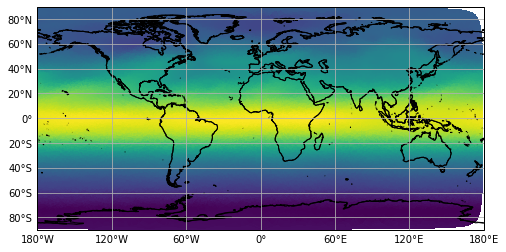

In [16]:
fig, ax = make_quick_map()
ax.tripcolor(triang, sample['O3'].values.flatten())
ax.coastlines()

Let's generalize our plotting utility function so that we can plot arbitrary data points

In [17]:
def make_map(nrows, ncols, lat, lon, projection=ccrs.PlateCarree()):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10),
                           subplot_kw=dict(projection=projection), sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            axes[row][col].coastlines(resolution='50m')
            gl = axes[row][col].gridlines(draw_labels=True)
            gl.xlabels_top = gl.ylabels_right = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            axes[row][col].set_aspect('equal')       
    triang = tri.Triangulation(lon, lat)
    return fig, axes, triang

In [18]:
def map_plotter(ds, data_var, nrows, ncols, lats, lons, lev_idx=0, cmap='viridis'):
    sample = ds.isel(lev=lev_idx, time=slice(0, nrows*ncols))[[data_var]]
    fig, axes, triang = make_map(nrows, ncols, lats, lons)
    idxs = nrows * ncols
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            tcp = axes[row][col].tripcolor(triang, sample[data_var].isel(time=idx).values.flatten(), cmap=cmap)
            axes[row][col].set_title(f'time={str(sample.time.values[idx])}')
    cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    fig.suptitle(f'{sample[data_var].long_name} \n @ {sample.lev.long_name}={sample.lev.values} {sample.lev.units}', fontsize=20)
    fig.colorbar(tcp, cax=cax, label=f'units={sample[data_var].units}', **kw)

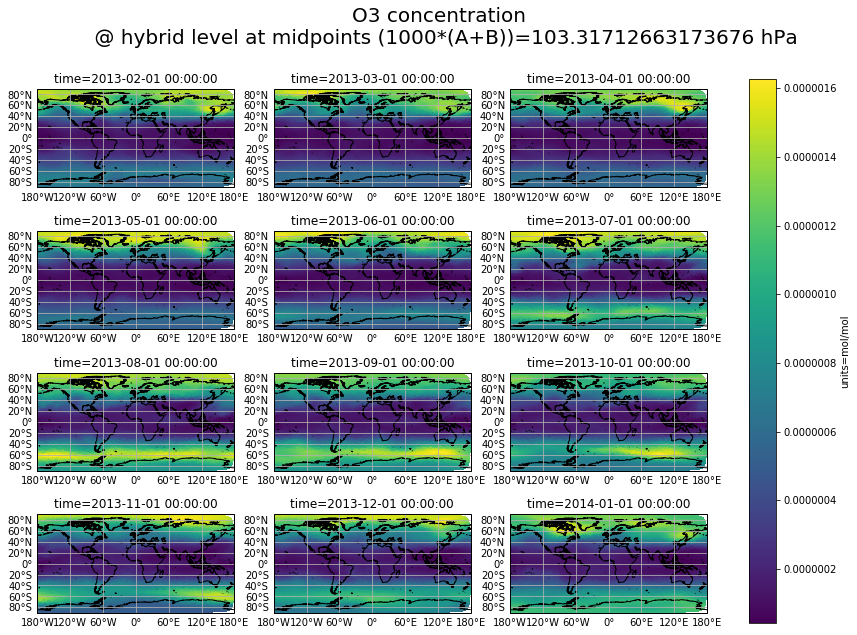

In [19]:
# Plot Ozone concentration from 12 time steps, at lev with index=10
map_plotter(ds, 'O3', 4, 3, lats, lons, lev_idx=10)

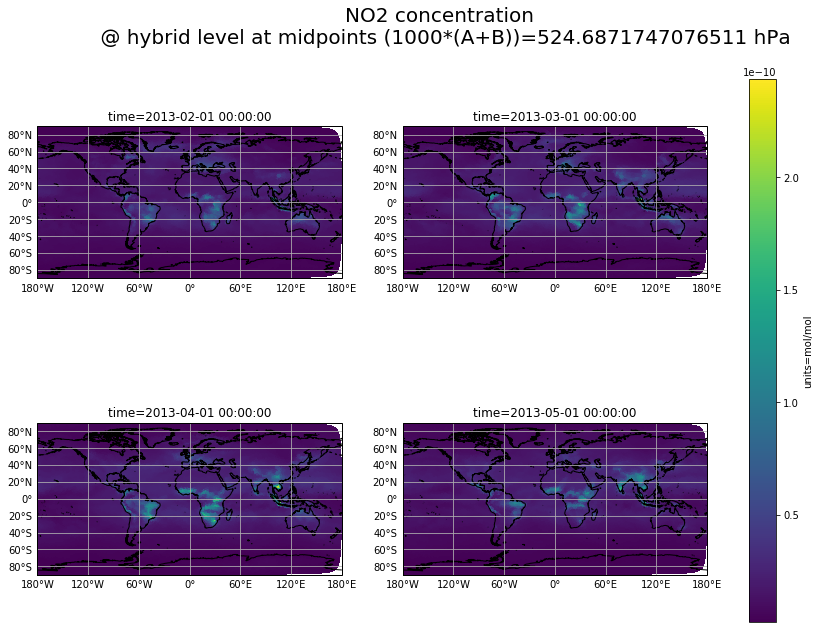

In [20]:
# Plot NO2 concentration from 4 time steps at lev with index=20
map_plotter(ds, 'NO2', 2, 2, lats, lons, lev_idx=20)

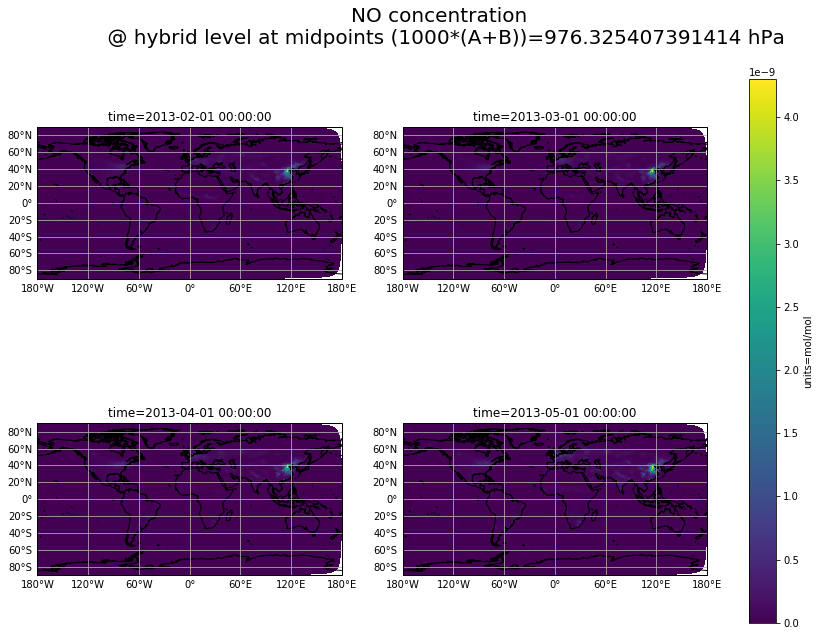

In [21]:
map_plotter(ds, 'NO', 2, 2, lats, lons, lev_idx=30)

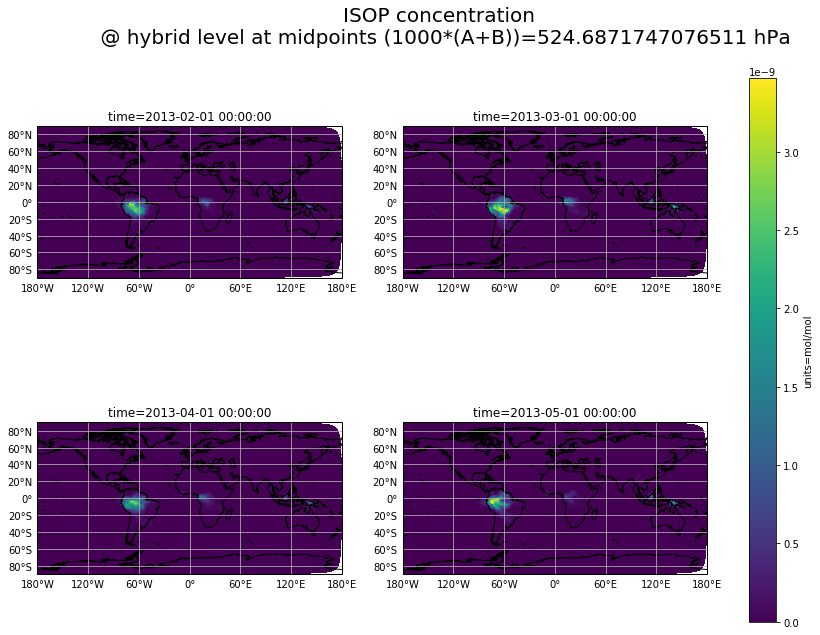

In [22]:
map_plotter(ds, 'ISOP', 2, 2, lats, lons, lev_idx=20)

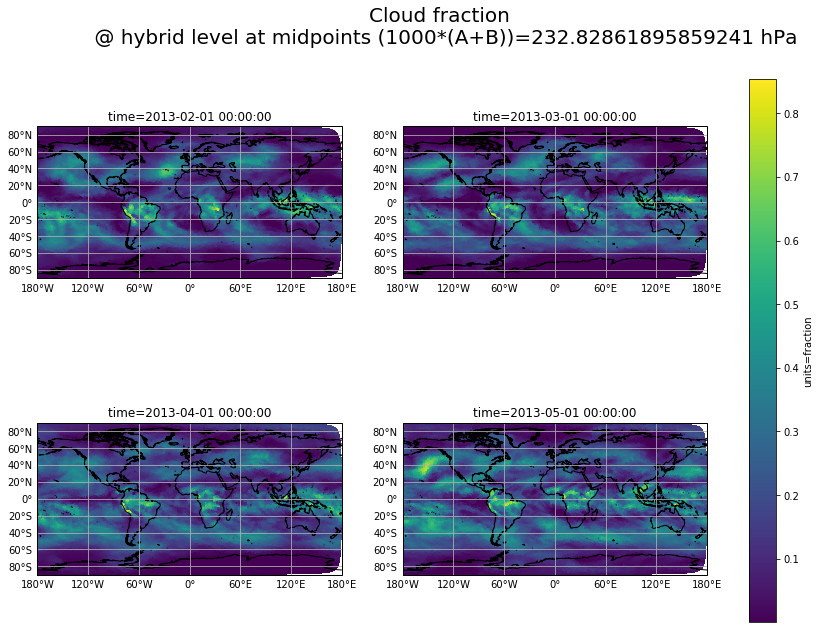

In [23]:
map_plotter(ds, 'CLOUD', 2, 2, lats, lons, lev_idx=15)

In [24]:
import cmocean
cmap = cmocean.cm.thermal

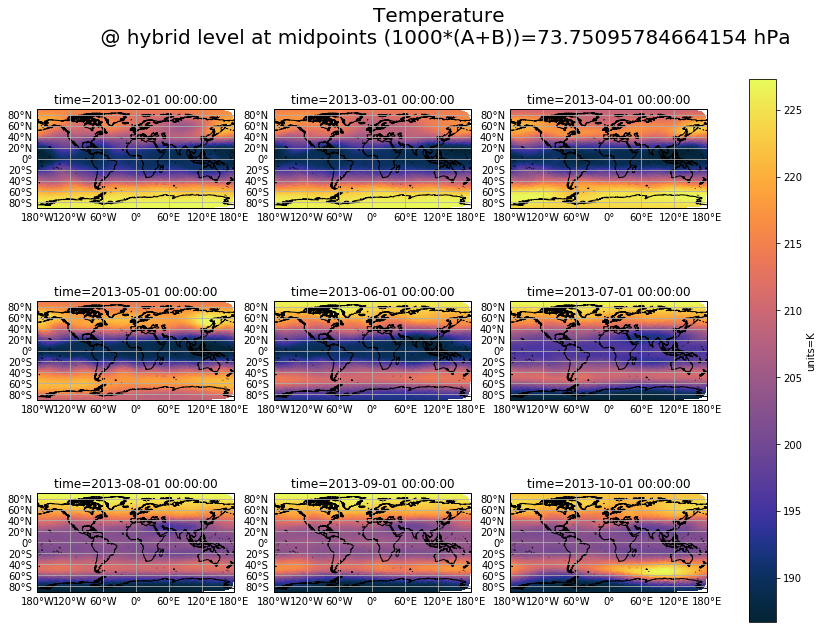

In [25]:
map_plotter(ds, 'T', 3, 3, lats, lons, lev_idx=8, cmap=cmap)

---

# Plotting other things
Plots of model results with aircraft observations on top (maps, curtains)

In [26]:
%load_ext watermark
%watermark --iversion -g  -m  -v -u -d

numpy      1.15.4
cmocean    2.0
xarray     0.12.1
matplotlib 3.0.3
cartopy    0.17.0
last updated: 2019-05-10 

CPython 3.7.3
IPython 7.1.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
Git hash   : 32714851c7cfab18d4cf1bac23439444df5597f6
